In [22]:
rm(list=ls())
library(caret)
library(readr)
library(scales)
library(parallelSVM)
library(ranger)
library(ggplot2)
library(dplyr)
options(warn=-1)

In [42]:
set.seed(2323)

In [43]:
df = read_csv( 'https://github.com/romeokienzler/developerWorks/raw/master/train.csv' )
df$label <- as.factor(df$label)

Parsed with column specification:
cols(
  .default = col_integer()
)
See spec(...) for full column specifications.


In [24]:
index <- createDataPartition(df$label,
                             times = 1,
                             p = 0.75,
                             list = FALSE)

train_set <- df[index, ]
test_set <- df[-index, ]

In [25]:
zeros <- sapply(train_set[,-1], function(x) all(x == 0))

train_set <- train_set[, c(TRUE, !zeros)]
train_set[,-1] <- lapply(train_set[,-1], rescale)

test_set <- test_set[, c(TRUE, !zeros)]
test_set[,-1] <- lapply(test_set[,-1], rescale)

In [26]:
start <- Sys.time()
model <- parallelSVM(label~., data = train_set, numberCores = 10)
pred <- predict(model, test_set[,2:ncol(test_set)])
Sys.time()-start

confusionMatrix(table(pred, test_set$label))

Time difference of 20.97485 mins

Confusion Matrix and Statistics

    
pred    0    1    2    3    4    5    6    7    8    9
   0 1004    0    6    1    3    5    7    2    4    8
   1    0 1148    6   13    6   11    3   18   24    6
   2    3    5  941   15    2    2    9    6   11    5
   3    3    2   10  949    0   41    1    2   23   16
   4    3    1   18    2  951   10    6   18    9   40
   5    8    8    5   52    2  853   19    1   47    5
   6    7    1   19   12    8   15  984    0    7    1
   7    0    3   13   11    1    2    0 1007    3   38
   8    4    2   24   22    1    5    5    0  879    4
   9    1    1    2   10   44    4    0   46    8  924

Overall Statistics
                                         
               Accuracy : 0.9184         
                 95% CI : (0.913, 0.9235)
    No Information Rate : 0.1116         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9093         
 Mcnemar's Test P-Value : NA             



In [27]:
models = list()
for (i in seq(1, 500, 50)){
  model_rf <- ranger(label~., data=train_set, num.trees=i)
  pred <- predict(model_rf, test_set[,2:ncol(test_set)])
  confu <- confusionMatrix(table(pred$predictions, test_set$label))
  acc <- confu$overall[1]
  models[[i]] <- c("Accuracy" = acc %>% as.numeric, "Number of Trees" = model_rf$num.trees)
}

Growing trees.. Progress: 84%. Estimated remaining time: 5 seconds.
Growing trees.. Progress: 58%. Estimated remaining time: 22 seconds.
Growing trees.. Progress: 42%. Estimated remaining time: 42 seconds.
Growing trees.. Progress: 84%. Estimated remaining time: 11 seconds.
Growing trees.. Progress: 35%. Estimated remaining time: 56 seconds.
Growing trees.. Progress: 72%. Estimated remaining time: 24 seconds.
Growing trees.. Progress: 30%. Estimated remaining time: 1 minute, 13 seconds.
Growing trees.. Progress: 59%. Estimated remaining time: 42 seconds.
Growing trees.. Progress: 88%. Estimated remaining time: 12 seconds.
Growing trees.. Progress: 24%. Estimated remaining time: 1 minute, 40 seconds.
Growing trees.. Progress: 50%. Estimated remaining time: 1 minute, 2 seconds.
Growing trees.. Progress: 75%. Estimated remaining time: 31 seconds.
Growing trees.. Progress: 22%. Estimated remaining time: 1 minute, 52 seconds.
Growing trees.. Progress: 45%. Estimated remaining time: 1 minute

In [31]:
accuracy_df <- data.frame("Accuracy"=unlist(sapply(models, `[[`, 1)),
                          "NTree"=unlist(sapply(models, `[[`, 2)))

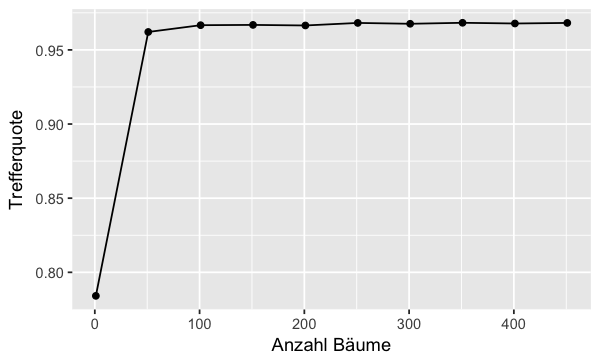

In [40]:
options(repr.plot.width=5, repr.plot.height=3)

accuracy_df %>% 
  ggplot(aes(x=NTree, y = Accuracy, group=1)) + 
  geom_point() +
  geom_line() +
  xlab("Anzahl Bäume") +
  ylab("Trefferquote")

In [41]:
model_rf <- ranger(label~., data=train_set, num.trees=250)
pred <- predict(model_rf, test_set[,2:ncol(test_set)])

confusionMatrix(table(pred$predictions, test_set$label))

Growing trees.. Progress: 34%. Estimated remaining time: 1 minute, 1 seconds.
Growing trees.. Progress: 69%. Estimated remaining time: 28 seconds.


Confusion Matrix and Statistics

   
       0    1    2    3    4    5    6    7    8    9
  0 1019    0    3    0    3    3    4    1    3    6
  1    0 1153    1    0    0    1    0    5    2    3
  2    0    6 1008   13    1    1    0    2    6    2
  3    1    3    2 1034    0   12    0    3   10   15
  4    0    1    6    3  988    1    1    8    4   17
  5    3    1    0   11    0  914    7    0   15    4
  6    3    1    7    2    4    5 1017    0    3    0
  7    0    4    5    6    1    2    0 1068    0   12
  8    5    2   12   10    2    5    5    0  966    4
  9    2    0    0    8   19    4    0   13    6  984

Overall Statistics
                                          
               Accuracy : 0.967           
                 95% CI : (0.9634, 0.9704)
    No Information Rate : 0.1116          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9634          
 Mcnemar's Test P-Value : NA              

Stat